<a href="https://colab.research.google.com/github/sophia-mai/predictive-glucose-insights/blob/main/Internship_Academy_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Estimating Carbs and Insulin Dosage: Option 1

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd

# Import Dataset
dex = pd.read_csv('/content/drive/MyDrive/Internship Academy/Clarity_Export_Parmar_Henna_2025-11-03_231446.csv')
#dex = pd.rad_csv('content/drive/MyDrive')
dex.head()

# Estimate Carbs and Insulin
import numpy as np

# Filter the Columns for EGV events and include 'Insulin Value (u)'
glucose_df = dex[dex['Event Type'] == "EGV"].copy()
glucose_df = glucose_df[['Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mg/dL)', 'Insulin Value (u)', 'Carb Value (grams)']]
glucose_df.rename(columns={
    'Timestamp (YYYY-MM-DDThh:mm:ss)': 'Timestamp',
    'Glucose Value (mg/dL)': 'Glucose',
    'Carb Value (u)': 'Carb Value',
    'Insulin Value (u)': 'Insulin Value'
    }, inplace = True)

# Convert 'Glucose' and 'Insulin Value (u)' to numeric, coercing errors
glucose_df['Timestamp'] = pd.to_datetime(glucose_df['Timestamp'])
glucose_df['Glucose'] = pd.to_numeric(glucose_df['Glucose'], errors='coerce')
glucose_df['Insulin Value'] = pd.to_numeric(glucose_df['Insulin Value'], errors='coerce')


# Sort by Timestamp
glucose_df.sort_values('Timestamp', inplace = True)
glucose_df.reset_index(drop = True, inplace = True)

# Compute Rate of Change and Rolling Differences
glucose_df['delta'] = glucose_df['Glucose'].diff()
glucose_df['delta_30min'] = glucose_df['Glucose'].diff(6) # 6 readings ~ 30 min (5 min intervals)
glucose_df['roc'] = glucose_df['delta'] / 5 # rate of change mg/dL per minute

# Detect Meal Events (Rapid Rise)
glucose_df['meal_event'] = (glucose_df['delta_30min'] > 30).astype(int)
glucose_df['carb_est'] = np.where(glucose_df['meal_event'] == 1, glucose_df['delta_30min'] * 1.2, 0)

# Detect Insulin Events (Rapid Drop)
glucose_df['insulin_event'] = (glucose_df['delta_30min'] < -30).astype(int)
glucose_df['insulin_est_units'] = np.where(glucose_df['insulin_event'] == 1, np.abs(glucose_df['delta_30min']) / 40, 0)

# Remove NaNs for relevant columns after calculations
glucose_df = glucose_df.dropna(subset=['Timestamp'])

# Save File
file_path = '/content/drive/MyDrive/Internship Academy/dexcom_with_estimates_2.csv'
glucose_df.to_csv(file_path, index = False)
print(f"File save to {file_path}")

display(glucose_df.head())

Mounted at /content/drive
File save to /content/drive/MyDrive/Internship Academy/dexcom_with_estimates_2.csv


,Timestamp,Glucose,Insulin Value,Carb Value (grams),delta,delta_30min,roc,meal_event,carb_est,insulin_event,insulin_est_units
0,2025-10-21 00:04:12,133.0,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0.0
1,2025-10-21 00:09:12,129.0,NaN,NaN,-4.0,NaN,-0.8,0,0.0,0,0.0
2,2025-10-21 00:14:12,124.0,NaN,NaN,-5.0,NaN,-1.0,0,0.0,0,0.0
3,2025-10-21 00:19:12,120.0,NaN,NaN,-4.0,NaN,-0.8,0,0.0,0,0.0
4,2025-10-21 00:24:12,116.0,NaN,NaN,-4.0,NaN,-0.8,0,0.0,0,0.0


In [ ]:
### CONSOLIDATE CARB AND INSULIN EVENTS for Option 1
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd

# Import Dataset
dex = pd.read_csv('/content/drive/MyDrive/Internship Academy/dexcom_with_estimates_2.csv')

from datetime import timedelta

def consolidate_daily_events(df, carb_col='carb_est', insulin_col='insulin_est_units',
                             timestamp_col='Timestamp', max_events_per_day=10, merge_window_min=90,
                             carb_cap = 75):
    """
    Consolidate small insulin/carb events into <= max_events_per_day realistic events per day.
    Events within merge_window_min minutes are merged together.
    """

    df = df.copy()

    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df = df.dropna(subset=[timestamp_col])

    # Extract Date Only for Grouping
    df['Date'] = df[timestamp_col].dt.date

    consolidated = []
    for date, group in df.groupby('Date'):
        g = group.copy().sort_values(timestamp_col)

        # Create Event Markers Where Insulin or Carbs > 0
        events = g[(g[carb_col] > 0) | (g[insulin_col] > 0)].copy()
        if events.empty:
            continue

        # Merge Close Events (within merge_window_min)
        merged_events = []
        current = events.iloc[0].copy()

        for _, row in events.iloc[1:].iterrows():
            delta_min = (row[timestamp_col] - current[timestamp_col]).total_seconds() / 60
            if delta_min <= merge_window_min:
                # Merge into Current Event
                current[carb_col] = min(max(current[carb_col], row[carb_col]), carb_cap)
                current[insulin_col] += row[insulin_col]
            else:
                merged_events.append(current)
                current = row.copy()

        merged_events.append(current)
        merged_df = pd.DataFrame(merged_events)

        # Keep only top N events by carb+insulin total
        merged_df['total_effect'] = merged_df[carb_col] + 20 * merged_df[insulin_col]
        merged_df = merged_df.nlargest(max_events_per_day, 'total_effect').sort_values(timestamp_col)

        consolidated.append(merged_df)

    if not consolidated:
        print("No events to consolidate.")
        return df

    consolidated_df = pd.concat(consolidated, ignore_index=True)

    # Map Consolidated Values Back to Main Dataframe
    df['Consolidated_Carbs_g'] = 0.0
    df['Consolidated_Insulin_ShortAct_u'] = 0.0

    for _, row in consolidated_df.iterrows():
        t = row[timestamp_col]
        idx = (df[timestamp_col] - t).abs().idxmin()
        df.loc[idx, 'Consolidated_Carbs_g'] = row[carb_col]
        df.loc[idx, 'Consolidated_Insulin_ShortAct_u'] = row[insulin_col]

    return df


# Apply Consolidation
glucose_df = consolidate_daily_events(dex)

# Save Updated Version
output_path2 = '/content/drive/MyDrive/Internship Academy/dexcom_with_estimates_2_consolidated.csv'
glucose_df.to_csv(output_path2, index=False)

Mounted at /content/drive


In [ ]:
### Estimating Carbs and Insulin Hovorka-Style Glucose-Insulin Model: Option 2
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Load CSV
dex = '/content/drive/MyDrive/Internship Academy/Clarity_Export_Parmar_Henna_2025-11-03_231446.csv'
dex = pd.read_csv(dex)

# Keep Only Glucose Rows (EGV) and Relevent Columns
glucose_df = dex[dex['Event Type'] == 'EGV'][['Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mg/dL)']].copy()
glucose_df.rename(columns = {
    'Timestamp (YYYY-MM-DDThh:mm:ss)': 'Timestamp',
    'Glucose Value (mg/dL)': 'Glucose',
}, inplace = True)

# Convert Datetime and Glucose to Numeric
glucose_df['Timestamp'] = pd.to_datetime(glucose_df['Timestamp'])
glucose_df["Glucose"] = pd.to_numeric(glucose_df['Glucose'], errors = 'coerce')

# Remove NaNs
glucose_df = glucose_df.dropna().sort_values('Timestamp').reset_index(drop = True)

# Sort by Time
glucose_df.sort_values('Timestamp', inplace = True)
glucose_df.reset_index(drop = True, inplace = True)

# Covert Timestamps to Minute Offsets (assuming 5-min intervals)
t_obs = np.arange(len(glucose_df)) * 5
G_obs = glucose_df['Glucose'].values

from scipy.integrate import solve_ivp

# Model Parameters (need to change)
p1, p2, p3 = 0.01, 0.02, 0.03

def hovorka_ode(t, y, u_meal_t, u_insulin_t):
  G, I = y
  dGdt = -p1 * G - p2 * I + u_meal_t(t)
  dIdt = -p3 * I + u_insulin_t(t)
  return [dGdt, dIdt]

def simulate_glucose(params, t_obs, G0):
  n_points = len(t_obs)
  n_meals = n_points // 6

  meals = params[:n_meals]
  insulins = params[n_meals:]

  # Define input functions based on these paramters
  def u_meal(t):
    idx = int(t // 30) if t < n_points * 5 else -1
    return meals[idx] if 0 <= idx < len(meals) else 0

  def u_insulin(t):
    idx = int(t // 30) if t < n_points * 5 else -1
    return insulins[idx] if 0 <= idx < len(insulins) else 0

  sol = solve_ivp(hovorka_ode, [t_obs[0], t_obs[-1]], [G0, 0],
                  t_eval = t_obs, args = (lambda t: u_meal(t), lambda t: u_insulin(t)))
  return sol.y[0]


from scipy.optimize import minimize

def loss_function(params):
    G_sim = simulate_glucose(params, t_obs, G_obs[0])
    return np.sum((G_sim - G_obs)**2)

# Initialize Guesses (zeros)
n_points = len(t_obs)
n_meals = n_points // 6
x0 = np.zeros(n_meals * 2)

# Add Small Random noise to Help Optimizer Explore
x0 += np.random.normal(0, 1, size=len(x0))

# Set Bounds: meals 0–100g, insulin 0–5u per half-hour (MAYBE CHANGE)
bounds = [(0, 100)] * n_meals + [(0, 5)] * n_meals

print("Running optimization (this may take a few minutes)...")
res = minimize(loss_function, x0, bounds=bounds, method='L-BFGS-B', options={'maxiter': 300})

params_est = res.x
meals_est = params_est[:n_meals]
insulin_est = params_est[n_meals:]
print("Optimization complete.")

# Each Meal/Insulin Estimate Corresponds to One 30-min Block (~6 readings)
block_size = 6
meal_array = np.repeat(meals_est, block_size)[:len(glucose_df)]
insulin_array = np.repeat(insulin_est, block_size)[:len(glucose_df)]

glucose_df['Estimated_Carbs_g'] = meal_array
glucose_df['Estimated_Insulin_ShortAct_u'] = insulin_array

# Add Fix Long-Acting Insulin (e.g., 20 units total)
glucose_df['Estimated_Insulin_LongAct_u'] = 20.0

# Save Dataset
output_path = '/content/drive/MyDrive/Internship Academy/dexcom_with_estimates.csv'
glucose_df.to_csv(output_path, index = False)

# Display Data
display(glucose_df.head())


import matplotlib.pyplot as plt
# Re-Simulate with Fitted Parameters
G_fit = simulate_glucose(params_est, t_obs, G_obs[0])

time_hours = t_obs / 60
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(time_hours, G_obs, label='Observed Glucose', color='blue')
ax1.plot(time_hours, G_fit, label='Fitted Glucose', color='orange', linestyle='--')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Glucose (mg/dL)')
ax1.legend(loc='upper left')

# Plot Meals/Insulin on Secondary Axis
ax2 = ax1.twinx()
ax2.bar(np.arange(n_meals)*0.5, meals_est, width=0.4, color='green', alpha=0.4, label='Estimated Carbs (g)')
ax2.bar(np.arange(n_meals)*0.5, insulin_est, width=0.4, color='red', alpha=0.4, label='Estimated Insulin (u)')
ax2.set_ylabel('Estimated Inputs')
ax2.legend(loc='upper right')

plt.title('Glucose Inversion: Estimated Meals and Insulin Over Time')
plt.show()

In [ ]:
### CONSOLIDATE CARB AND INSULIN EVENTS for Option 2
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd

# Import Dataset
glucose_df = pd.read_csv('/content/drive/MyDrive/Internship Academy/dexcom_with_estimates.csv')


from datetime import timedelta

def consolidate(df, carb_col='Estimated_Carbs_g', insulin_col='Estimated_Insulin_ShortAct_u',
                timestamp_col='Timestamp', max_events_per_day=10, merge_window_min=60):
  df = df.copy()
  df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors = 'coerce')
  df = df.dropna(subset = [timestamp_col])
  df['Date'] = df[timestamp_col].dt.date

  consolidated = []
  for date, group in df.groupby('Date'):
    g = group.copy().sort_values(timestamp_col)

    # Create Event Markers where Insulin or Carbs > 0
    events = g[(g[carb_col] > 0) | (g[insulin_col] > 0)].copy()
    if events.empty:
      continue

    # Merge close events (within merge_window_min)
    merged_events = []
    current = events.iloc[0].copy()

    for _, row in events.iloc[1:].iterrows():
      delta_min = (row[timestamp_col] - current[timestamp_col]).total_seconds() / 60
      if delta_min <= merge_window_min:
        current[carb_col] += row[carb_col]
        current[insulin_col] += row[insulin_col]
      else:
        merged_events.append(current)
        current = row.copy()

    merged_events.append(current)
    merged_df = pd.DataFrame(merged_events)

    # Keep only top N events by carb + insulin total
    merged_df['total_effect'] = merged_df[carb_col] + 20 * merged_df[insulin_col]
    merged_df = merged_df.nlargest(max_events_per_day, 'total_effect').sort_values(timestamp_col)

    consolidated.append(merged_df)

  consolidated_df = pd.concat(consolidated, ignore_index = True)

  # Map Consolidated Values Back to the Main Dataframe
  df['Consolidated_Carbs_g'] = 0.0
  df['Consolidated_Insulin_ShortAct_u'] = 0.0

  for _, row in consolidated_df.iterrows():
    t = row[timestamp_col]
    idx = (df[timestamp_col] - t).abs().idxmin()
    df.loc[idx, 'Consolidated_Carbs_g'] = row[carb_col]
    df.loc[idx, 'Consolidated_Insulin_ShortAct_u'] = row[insulin_col]

  return df

# Apply Consolidation
glucose_df = consolidate(glucose_df)

# Save Updated Verison
output_path = '/content/drive/MyDrive/Internship Academy/dexcom_with_estimates_consolidated.csv'
glucose_df.to_csv(output_path, index = False)

display(glucose_df.head())

Option 1 is more accurate.

In [ ]:
### Validation Data Harmonization
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd

validation = pd.read_csv('/content/drive/MyDrive/Internship Academy/Clarity_Export_Parmar_Henna_2025-11-22_205142.csv')

# Filter the Columns
validation_df = validation.copy()
validation_df = validation_df[validation_df["Event Subtype"] != "Long-Acting"]
validation_df = validation[['Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mg/dL)', 'Insulin Value (u)', 'Carb Value (grams)']]
validation_df.rename(columns={
    'Timestamp (YYYY-MM-DDThh:mm:ss)': 'Timestamp',
    'Glucose Value (mg/dL)': 'Glucose',
    'Carb Value (grams)': 'Carb Value',
    'Insulin Value (u)': 'Insulin Value'
    }, inplace = True)
validation_df = validation_df.dropna(subset=["Timestamp"])

# Merge with Apple Health Data
apple = pd.read_csv('/content/drive/MyDrive/Internship Academy/HealthAutoExport-2025-10-20-2025-11-03_20251111_185732.csv')

validation_df['timestamp'] = pd.to_datetime(validation_df['Timestamp'])
apple['timestamp'] = pd.to_datetime(apple['Date/Time'])

validation_df = validation_df.set_index('timestamp').sort_index()
apple = apple.set_index('timestamp').sort_index()

validation_df = pd.merge_asof(validation_df, apple, on = "timestamp", direction = "nearest", tolerance = pd.Timedelta("3min"))
validation_df = validation_df.reset_index()

validation_df = validation_df.drop(columns=["Timestamp", "Date/Time", "Breathing Disturbances (count)", "Basal Body Temperature (degF)", "Respiratory Rate (count/min)", "Apple Move Time (min)"])
validation_df.rename(columns={
    'timestamp': 'Timestamp',
    'Apple Exercise Time (min)': 'Exercise Time',
    'Heart Rate [Min] (count/min)': 'Heart Rate [Min]',
    'Heart Rate [Max] (count/min)': 'Heart Rate [Max]',
    'Heart Rate [Avg] (count/min)': 'Heart Rate [Avg]',
    'Step Count (count)': 'Step Count'
    }, inplace = True)

# Save Data
validation_df.to_csv("/content/drive/MyDrive/Internship Academy/validation.csv", index = False)
validation_df.head()

Mounted at /content/drive


/tmp/ipython-input-3267537855.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df.rename(columns={


,index,Timestamp,Glucose,Insulin Value,Carb Value,Exercise Time,Heart Rate [Min],Heart Rate [Max],Heart Rate [Avg],Step Count
0,0,2025-11-03 00:03:33,119,NaN,NaN,NaN,80.0,80.0,80.0,NaN
1,1,2025-11-03 00:08:33,120,NaN,NaN,NaN,NaN,NaN,NaN,11.53
2,2,2025-11-03 00:13:34,111,NaN,NaN,NaN,NaN,NaN,NaN,17.95
3,3,2025-11-03 00:18:33,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2025-11-03 00:23:33,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
### Harmonize Option 1 (dexcom_with_estimates_2_consolidated.csv) and Apple Health Data (HealthAutoExport-2025-10-20-2025-11-03.csv)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd

dex = pd.read_csv('/content/drive/MyDrive/Internship Academy/dexcom_with_estimates_2_consolidated.csv')
apple = pd.read_csv('/content/drive/MyDrive/Internship Academy/HealthAutoExport-2025-10-20-2025-11-03.csv')

dex['timestamp'] = pd.to_datetime(dex['Timestamp'])
apple['timestamp'] = pd.to_datetime(apple['Date/Time'])

dex = dex.set_index('timestamp').sort_index()
apple = apple.set_index('timestamp').sort_index()

merged = pd.merge_asof(dex, apple, on = "timestamp", direction = "nearest", tolerance = pd.Timedelta("3min"))
merged = merged.reset_index()

# Note***: Probably want to delete some columns we don't want
merged = merged.drop(columns=["Timestamp","Date", "Date/Time", "Breathing Disturbances (count)", "Basal Body Temperature (degF)", "Respiratory Rate (count/min)", "Apple Move Time (min)", "delta", "delta_30min", "roc", "meal_event", "carb_est", "insulin_event", "insulin_est_units", "Insulin Value", "Carb Value (grams)"])
merged.rename(columns={
    'timestamp': 'Timestamp',
    'Apple Exercise Time (min)': 'Exercise Time',
    'Heart Rate [Min] (count/min)': 'Heart Rate [Min]',
    'Heart Rate [Max] (count/min)': 'Heart Rate [Max]',
    'Heart Rate [Avg] (count/min)': 'Heart Rate [Avg]',
    'Consolidated_Carbs_g': 'Carb Value',
    'Consolidated_Insulin_ShortAct_u': 'Insulin Value',
    'Step Count (count)': 'Step Count'
    }, inplace = True)

merged.to_csv("/content/drive/MyDrive/Internship Academy/harmonized_dexcom_applehealth.csv", index = False)
merged.head()

Mounted at /content/drive


,index,Timestamp,Glucose,Carb Value,Insulin Value,Exercise Time,Heart Rate [Min],Heart Rate [Max],Heart Rate [Avg],Step Count
0,0,2025-10-21 00:04:12,133.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1,2025-10-21 00:09:12,129.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2,2025-10-21 00:14:12,124.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,3,2025-10-21 00:19:12,120.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,4,2025-10-21 00:24:12,116.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
#imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

%matplotlib inline

path = '/content/drive/MyDrive/Internship Academy/harmonized_dexcom_applehealth.csv'

df = pd.read_csv(path)

#cleanup
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

#only columns needed
# glucose and carb value
df['Glucose'] = pd.to_numeric(df['Glucose'], errors='coerce')
df['Carb Value'] = pd.to_numeric(df['Carb Value'], errors='coerce').fillna(0)

df = df.dropna(subset=['Glucose']).reset_index(drop=True)

print(df.head())
print(df.columns)

   index           Timestamp  Glucose  Carb Value  Insulin Value  \
0      0 2025-10-21 00:04:12    133.0         0.0            0.0   
1      1 2025-10-21 00:09:12    129.0         0.0            0.0   
2      2 2025-10-21 00:14:12    124.0         0.0            0.0   
3      3 2025-10-21 00:19:12    120.0         0.0            0.0   
4      4 2025-10-21 00:24:12    116.0         0.0            0.0   

   Exercise Time  Heart Rate [Min]  Heart Rate [Max]  Heart Rate [Avg]  \
0            NaN               NaN               NaN               NaN   
1            NaN               NaN               NaN               NaN   
2            NaN               NaN               NaN               NaN   
3            NaN               NaN               NaN               NaN   
4            NaN               NaN               NaN               NaN   

   Step Count  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
Index(['index', 'Timestamp', 'Glucose', 'Carb Valu

In [ ]:
history_len = 12 # past 60 min
future_len = 24 # next 120 min
carb_threshold = 0.1 # >0 is a meal

X_histories = []
X_carbs = []
y_future = []

glucose = df['Glucose'].values
carbs = df['Carb Value'].values

for i in range(len(df)):
  if carbs[i] > carb_threshold:
    if i - history_len < 0 or i + future_len >= len(df):
      continue

    past_glucose = glucose[i - history_len:i]
    future_glucose = glucose[i:i + future_len]
    carb_feat = carbs[i]

    if np.isnan(past_glucose).any() or np.isnan(future_glucose).any():
      continue

    X_histories.append(past_glucose.reshape(-1, 1))
    X_carbs.append([carb_feat])
    y_future.append(future_glucose)


X_histories = np.array(X_histories, dtype=np.float32)
X_carbs = np.array(X_carbs, dtype=np.float32)
y_future = np.array(y_future, dtype=np.float32)

print("Num samples:", X_histories.shape[0])
print("X_histories shape:", X_histories.shape)  # (N, 12, 1)
print("X_carbs shape:", X_carbs.shape)          # (N, 1)
print("y_future shape:", y_future.shape)        # (N, 24)

Num samples: 78
X_histories shape: (78, 12, 1)
X_carbs shape: (78, 1)
y_future shape: (78, 24)


In [ ]:
class GlucoseMealDataset(Dataset):
  def __init__(self, X_hist, X_carbs, y):
    self.X_hist = torch.from_numpy(X_hist)
    self.X_carbs = torch.from_numpy(X_carbs)
    self.y = torch.from_numpy(y)

  def __len__(self):
    return self.X_hist.shape[0]

  def __getitem__(self, idx):
    return self.X_hist[idx], self.X_carbs[idx], self.y[idx]

dataset = GlucoseMealDataset(X_histories, X_carbs, y_future)

#split

val_ratio = 0.2
n_total = len(dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train samples: ", len(train_dataset))
print("Val samples: ", len(val_dataset))

Train samples:  63
Val samples:  15


### Build LSTM Model

In [ ]:
class GlucoseLSTM(nn.Module):
  #nn.Module
  '''
     "Base class for all neural network modules.
     Your models should also subclass this class."
     https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
  '''

  def __init__(self, feature_dim=1, hidden_size=64):
    """
    feature_dim: number of extra features (carbs = 1)
    hidden_size: size of the LSTM hidden state
    """
    super().__init__()

    # LSTM layer
    # input size = 1 -> each timestep has one value(glucose)
    # hidden size -> number of units LSTM uses
    # batch_first = True
    self.lstm = nn.LSTM(
        input_size = 1,
        hidden_size=hidden_size,
        batch_first=True
    )

    # Fully connected (feed forward) layers
    # FC network takes
    # [LSTM hidden state] concatenated with carb value
    # vector of size: hidden size + feature dim
    # putputs 24 numbers = next 2 hours of glucose
    self.fc = nn.Sequential(
        nn.Linear(hidden_size + feature_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 24)
    )

  def forward(self, glucose_history, meal_features):
    """
      glucose_history: tensor of shape (batch, 12, 1)
                        (past 60 minutes of glucose)
      meal_features: tensor of shape (batch, feature_dim)
                      (here: carbs at meal time)
    """
    # lstm_out: outputs for each time stamp
    # h_n: final hidden state
    lstm_out, (h_n, _) = self.lstm(glucose_history)


    # extract final hidden state
    # h_n has num_layers, batch, hidden size
    # h_n[-1] selects the last layer

    h = h_n[-1]

    x = torch.cat([h, meal_features], dim=1)

    #each sample gets a 24 point prediction for next two hours
    out = self.fc(x)

    return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GlucoseLSTM(hidden_size=64).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



#Train model

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0

  for g_hist, carb_feat, y in train_loader:
    g_hist = g_hist.to(device)
    carb_feat = carb_feat.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    preds = model(g_hist, carb_feat)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * g_hist.size(0)

  train_loss /= len(train_dataset)

  model.eval()

  val_loss = 0.0
  with torch.no_grad():
    for g_hist, carb_feat, y in val_loader:
      g_hist = g_hist.to(device)
      carb_feat = carb_feat.to(device)
      y = y.to(device)

      preds = model(g_hist, carb_feat)
      loss = criterion(preds, y)
      val_loss += loss.item() * g_hist.size(0)

  val_loss /= len(val_dataset)

  print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



Epoch 1/20 | Train Loss: 47970.1755 | Val Loss: 43084.9766
Epoch 2/20 | Train Loss: 47696.0987 | Val Loss: 42816.3711
Epoch 3/20 | Train Loss: 47411.0555 | Val Loss: 42544.5352
Epoch 4/20 | Train Loss: 47135.1805 | Val Loss: 42265.8555
Epoch 5/20 | Train Loss: 46847.8279 | Val Loss: 41978.5117
Epoch 6/20 | Train Loss: 46560.7530 | Val Loss: 41679.3633
Epoch 7/20 | Train Loss: 46243.4105 | Val Loss: 41367.2852
Epoch 8/20 | Train Loss: 45920.3792 | Val Loss: 41039.1602
Epoch 9/20 | Train Loss: 45578.8589 | Val Loss: 40692.6211
Epoch 10/20 | Train Loss: 45223.8105 | Val Loss: 40325.0508
Epoch 11/20 | Train Loss: 44844.8160 | Val Loss: 39934.9648
Epoch 12/20 | Train Loss: 44443.4699 | Val Loss: 39520.5664
Epoch 13/20 | Train Loss: 44006.8190 | Val Loss: 39081.2812
Epoch 14/20 | Train Loss: 43553.6881 | Val Loss: 38614.9102
Epoch 15/20 | Train Loss: 43067.7504 | Val Loss: 38120.5195
Epoch 16/20 | Train Loss: 42567.2582 | Val Loss: 37594.6875
Epoch 17/20 | Train Loss: 42003.1574 | Val Loss: 

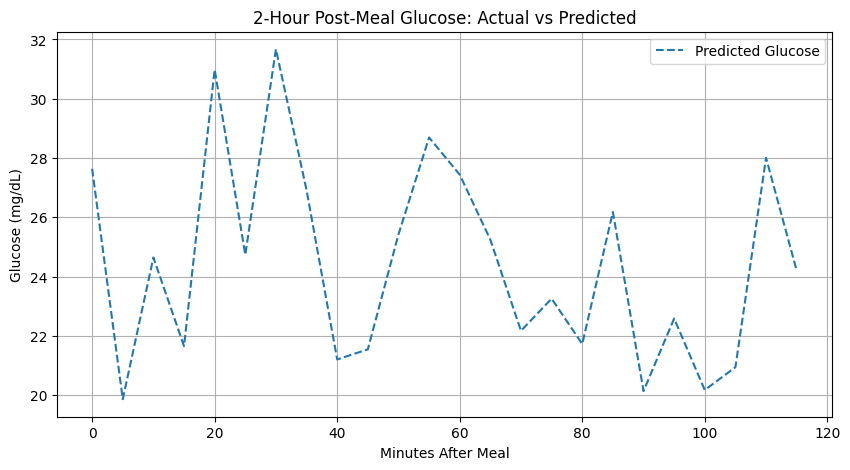

In [ ]:
model.eval()

g_hist, carb_feat, y_true = val_dataset[0]

g_hist_batch = g_hist.unsqueeze(0).to(device)
carb_feat_batch = carb_feat.unsqueeze(0).to(device)

with torch.no_grad():
  y_pred = model(g_hist_batch, carb_feat_batch).cpu().numpy().flatten()

y_true = y_true.numpy().flatten()

t = np.arange(0, len(y_true) * 5, 5)

plt.figure(figsize=(10,5))
plt.plot(t, y_pred, label="Predicted Glucose", linestyle="--")
plt.xlabel("Minutes After Meal")
plt.ylabel("Glucose (mg/dL)")
plt.title("2-Hour Post-Meal Glucose: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()
